In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Importando a base de dados para treino

In [13]:
# importando o dataset e vendo uma prévia do dataframe
dataset_train = pd.read_csv("desafio_manutencao_preditiva_treino.csv")
dataset_train.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


In [14]:
# verificando se existem NaN values no dataframe
nan_values = dataset_train.isna()
print(nan_values.sum())

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64


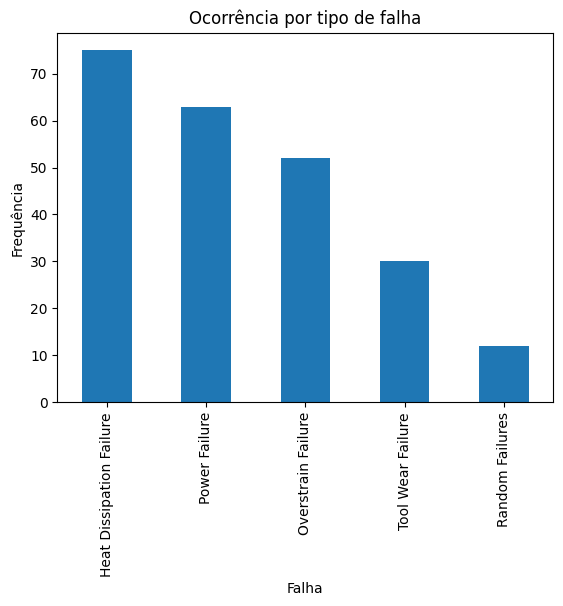

In [15]:
dataset_train[dataset_train['failure_type'] != 'No Failure']['failure_type'].value_counts().plot(kind='bar')
plt.title("Ocorrência por tipo de falha")
plt.xlabel("Falha")
plt.ylabel("Frequência")
plt.show()

# Testando correlações para a escolha do modelo a ser utilizado

In [16]:
# vamos verificar se as variáveis são dependentes ou independentes entre si
# para isso, calcularemos as correlações entre cada uma das variáveis
list_corr = []
for i in range(5):
    linha = []
    for j in range(5):
        col1 = dataset_train.iloc[:, i+3]
        col2 = dataset_train.iloc[:, j+3]
        corr = col1.corr(col2)
        linha.append(corr)
    list_corr.append(linha)

dataframe_corr = pd.DataFrame(list_corr, columns=['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min'],
                             index=['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min'])
dataframe_corr

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
air_temperature_k,1.000000,0.875724,0.035903,-0.023257,0.021078
process_temperature_k,0.875724,1.000000,0.033379,-0.024457,0.020298
rotational_speed_rpm,0.035903,0.033379,1.000000,-0.875989,-0.001290
torque_nm,-0.023257,-0.024457,-0.875989,1.000000,-0.004343
tool_wear_min,0.021078,0.020298,-0.001290,-0.004343,1.000000


# Treinando o modelo de ML

In [17]:
# as variáveis se monstraram independentes entre si na maioria dos casos
# vamos utilizar o modelo de Decision Tree
# testaremos o modelo utilizando 80% para treinamento do modelo e 20% para teste
# aqui eu utilizei apenas as colunas com dados numéricos com exceção da udi
# acredito que deveria ter utilizado a coluna type também, mas não consegui fazer isto
# pensei em transformar as letras em números mas concluí que isto resultaria em erros na precisão do modelo
X = dataset_train.iloc[:, 3:8]
y = dataset_train.iloc[:, 8]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

predictions_train = model.predict(X_test)

accuracy_score(y_test, predictions_train)

0.9767616191904048

In [18]:
# sabemos que para o treino com parte da base de dados, a acurácia fica em torno de 97%
# agora treinaremos o modelo com 100% da base de dados para maior precisão
X = dataset_train.iloc[:, 3:8]
y = dataset_train.iloc[:, 8]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

predictions_train = model.predict(X_test)

accuracy_score(y_test, predictions_train)

1.0

In [19]:
dataset_train.groupby('failure_type')["product_id"].count()

failure_type
Heat Dissipation Failure      75
No Failure                  6435
Overstrain Failure            52
Power Failure                 63
Random Failures               12
Tool Wear Failure             30
Name: product_id, dtype: int64

# Importando a base de dados para teste

In [20]:
# vamos importar o csv de teste do modelo e ajustar as colunas
# assim como fizemos no csv de treino
dataset_test = pd.read_csv("desafio_manutencao_preditiva_teste.csv")
dataset_test = dataset_test.iloc[:, 3:]
dataset_test.isna().sum()

air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
dtype: int64

In [21]:
# aplicando o modelo para esta nova base de dados nomeada de dataset_test
predictions_test = model.predict(dataset_test)
print(predictions_test)

['No Failure' 'No Failure' 'No Failure' ... 'No Failure' 'No Failure'
 'No Failure']


In [22]:
# adicionamos a array predictions_test à uma cópia do dataset_test
# e nomeamos a nova coluna de predictedValues
dataset_predicted = dataset_test.copy()

dataset_predicted['predictedValues'] = predictions_test

dataset_predicted.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,predictedValues
0,297.5,308.6,1793,26.7,70,No Failure
1,300.7,310.5,1536,47.4,192,No Failure
2,297.2,308.4,1460,42.1,41,No Failure
3,299.4,309.1,1670,35.9,68,No Failure
4,304.1,313.1,1550,30.9,9,No Failure


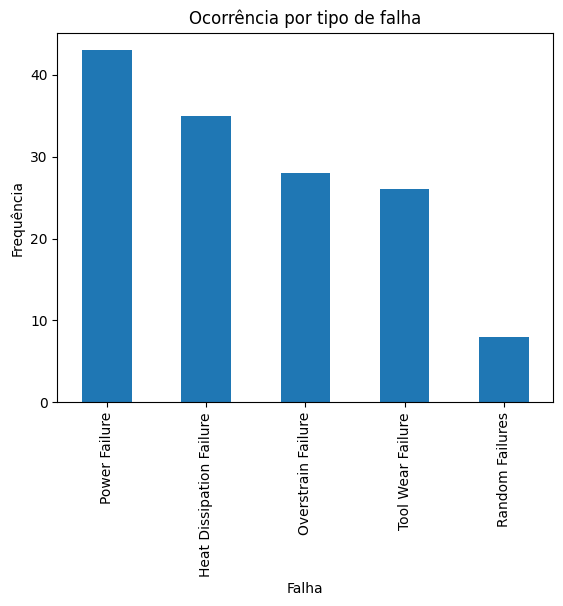

In [24]:
dataset_predicted[dataset_predicted['predictedValues'] != 'No Failure']['predictedValues'].value_counts().plot(kind='bar')
plt.title("Ocorrência por tipo de falha")
plt.xlabel("Falha")
plt.ylabel("Frequência")
plt.show()

In [53]:
# exportando o dataframe com as colunas índex e predictedValues para o formato .csv
planilha_excel = dataset_predicted['predictedValues']

planilha_excel.to_csv("predicted.csv", index=True)